In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import seaborn as sns
import operator
import math

%matplotlib inline

/home/maxime/local/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def unique(df):
    """
    tool to visualize the content of the DataFrame
    """
    for col in df.columns:
        l = len(df[col].unique())
        
        print(col+' : ', l)
        print(df[col].unique())
        print('-----------------------------------------------------')

In [70]:
df_init = pd.read_csv('data/train.csv',sep=';')
df_eval = pd.read_csv('data/test.csv', sep=';')
df_init.head()

,VOIE_DEPOT,COUNTRY,SOURCE_BEGIN_MONTH,APP_NB,APP_NB_PAYS,APP_NB_TYPE,FISRT_APP_COUNTRY,FISRT_APP_TYPE,LANGUAGE_OF_FILLING,FIRST_CLASSE,...,oecd_NB_BACKWARD_NPL,IDX_ORIGIN,SOURCE_IDX_ORI,IDX_RADIC,SOURCE_IDX_RAD,VARIABLE_CIBLE,PRIORITY_MONTH,FILING_MONTH,PUBLICATION_MONTH,BEGIN_MONTH
0,EURO-PCT,US,D0,1,1,1,US,COMPAGNY,en,A61K9/48,...,0.000,1.000000,IMPUT,1.00,IMPUT,GRANTED,09/1995,08/1996,03/1997,09/1995
1,EURO-PCT,DE,D0,1,1,1,DE,COMPAGNY,de,C08G65/26,...,0.000,1.000000,IMPUT,1.00,IMPUT,GRANTED,11/1999,11/2000,05/2001,11/1999
2,VOIE DIRECTE,JP,D0,1,1,1,JP,COMPAGNY,en,G11B15/07,...,0.125,0.897778,CALC,1.00,IMPUT,GRANTED,06/1992,05/1993,12/1993,06/1992
3,VOIE DIRECTE,GB,D0,1,1,1,GB,COMPAGNY,en,F25B41/04,...,0.000,1.000000,IMPUT,1.00,IMPUT,GRANTED,05/1994,05/1995,11/1995,05/1994
4,VOIE DIRECTE,DE,D0,1,1,1,DE,COMPAGNY,de,H01F17/06,...,0.000,0.625000,CALC,0.25,CALC,GRANTED,12/1988,11/1989,06/1990,12/1988


# Train test split

In [71]:
df_train, df_test = train_test_split(df_init, test_size=0.2, random_state=42)
df_train.head()

,VOIE_DEPOT,COUNTRY,SOURCE_BEGIN_MONTH,APP_NB,APP_NB_PAYS,APP_NB_TYPE,FISRT_APP_COUNTRY,FISRT_APP_TYPE,LANGUAGE_OF_FILLING,FIRST_CLASSE,...,oecd_NB_BACKWARD_NPL,IDX_ORIGIN,SOURCE_IDX_ORI,IDX_RADIC,SOURCE_IDX_RAD,VARIABLE_CIBLE,PRIORITY_MONTH,FILING_MONTH,PUBLICATION_MONTH,BEGIN_MONTH
140152,EURO-PCT,US,D0,1,1,0,US,(MISSING),en,A61B17/068,...,0.00,1,IMPUT,1,IMPUT,NOT GRANTED,07/2007,07/2007,01/2009,07/2007
255604,VOIE DIRECTE,US,D0,1,1,1,US,COMPAGNY,en,G07F13/06,...,0.25,0,CALC,1,IMPUT,GRANTED,08/1999,08/2000,12/2003,08/1999
205875,VOIE DIRECTE,NaN,D1,1,1,1,IT,COMPAGNY,it,G11C11/34,...,0.00,0,CALC,1,IMPUT,GRANTED,NaN,06/2003,12/2004,06/2003
56992,EURO-PCT,US,D0,1,1,1,US,COMPAGNY,en,C07D401/12,...,0.00,1,IMPUT,1,IMPUT,GRANTED,07/1991,06/1992,01/1993,07/1991
106012,EURO-PCT,US,D0,1,1,1,US,COMPAGNY,en,A61M1/00,...,0.00,1,IMPUT,1,IMPUT,NOT GRANTED,11/2005,11/2006,05/2007,11/2005


In [72]:
colList = ['FISRT_APP_COUNTRY', 'FIRST_CLASSE', 'MAIN_IPC', 'FISRT_INV_COUNTRY']

#
# ------------ Preprocessings -------------------------------------------------------------
#

In [73]:
class Preprocessings:
    
    def __init__(self, colList):
        # list of columns with to many categories
        self.colList = colList     
            
        
    def datetime_processings(self, df):
        # converting string dates in dateTime format :
        df.PRIORITY_MONTH = pd.to_datetime(df.PRIORITY_MONTH, format='%m/%Y')
        df.FILING_MONTH = pd.to_datetime(df.FILING_MONTH, format='%m/%Y')
        df.PUBLICATION_MONTH = pd.to_datetime(df.PUBLICATION_MONTH, format='%m/%Y')
        df.BEGIN_MONTH = pd.to_datetime(df.BEGIN_MONTH, format='%m/%Y')

        # PRIORITY_MONTH = BEGIN_MONTH :
        df = df.drop(['PRIORITY_MONTH'], axis=1)

        # creating features of duration between dates :
        df['filing-begin'] = (df.FILING_MONTH - df.BEGIN_MONTH).dt.days
        df['pub-filing'] = (df.PUBLICATION_MONTH - df.FILING_MONTH).dt.days
        df['pub_year'] = df.PUBLICATION_MONTH.dt.year
        df = df.drop(['FILING_MONTH', 'PUBLICATION_MONTH','BEGIN_MONTH'], axis=1)
        
        df = df.drop('cited_nmiss', axis=1)
        
        return df
        
    def cat_to_codes(self, df, eval_data=False):
        """
        converting categorical data into numerical codes :
        NaN's will be replaced by -1
        And replacing -1 by the meadian value of each categorical column
        """
        if not(eval_data):
            for col in self.cat_columns:
                df[col] = df[col].astype('category').cat.codes
                
            df[self.cat_columns] = df[self.cat_columns].replace(-1, df[self.cat_columns].median())
                
        else:
            columns = self.cat_columns
            columns.remove('VARIABLE_CIBLE')
            for col in columns:
                df[col] = df[col].astype('category').cat.codes
            
            df[columns] = df[columns].replace(-1, df[columns].median())
        
        

        return df

    def insert_scores(self, df):
        """
        creating continuous features from categorical
        """
        df = pd.merge(df, self.df_success_index1, on=['COUNTRY', 'TECHNOLOGIE_SECTOR'], how='left')
        df = pd.merge(df, self.df_success_index2, on=['COUNTRY', 'TECHNOLOGIE_FIELD'], how='left')
        df = pd.merge(df, self.df_country_score, on='COUNTRY', how='left')
        df = pd.merge(df, self.df_tech_sec_score, on='TECHNOLOGIE_SECTOR', how='left')
        df = pd.merge(df, self.df_tech_field_score, on='TECHNOLOGIE_FIELD', how='left')
        
        return df

        
    def reducing(self, df):
        """
        reducing the continous features to a distribution with mean=0 std=1
        """
        df[self.cont_cols] = (df[self.cont_cols] - df[self.cont_cols].mean())/df[self.cont_cols].std()
        
        return df
    
    def oneHot(self, df):
        
        temp = self.onehotencoder.transform(df[self.onehot_cols].values)

        cat_cols = []
        for j in range(len(self.onehot_cols)):
            for i in range(self.onehotencoder.feature_indices_[j+1]-self.onehotencoder.feature_indices_[j]):
                cat_cols.append(self.onehot_cols[j]+'_'+str(i))

        df_temp = pd.DataFrame(temp, columns=cat_cols)
        
        df = pd.concat([df, df_temp], axis=1, join='inner')
        df = df.drop(self.onehot_cols,axis=1)

        return df
    
    def create_score(self, df, columns, score_name):
        df_score = df.groupby(columns).mean().add_suffix('_mean').reset_index()
        columns.append('VARIABLE_CIBLE_mean')
        df_score = df_score[columns]
        df_score = df_score.rename(columns = {'VARIABLE_CIBLE_mean' : score_name})
        
        return df_score
    
    def drop_cat_col(self, df, columns):
        df = df.drop(columns, axis=1)
        self.cat_columns2 = [col for col in self.cat_columns if col not in columns]
        return df
    
    def fit_transform(self, df):
        
        df = df.drop(self.colList, axis=1)
        df = self.datetime_processings(df)
        
        ###
        self.cat_columns = df.select_dtypes(['object']).columns.tolist()
        self.cont_cols = [col for col in df.columns if col not in self.cat_columns]
        ###
        
        df = self.cat_to_codes(df)
        
        ###
        self.df_tech_sec_score = self.create_score(df, ['TECHNOLOGIE_SECTOR'], 'tech_sec_score')
        self.df_success_index1 = self.create_score(df, ['COUNTRY', 'TECHNOLOGIE_SECTOR'], 'success_index1')
        self.df_success_index2 = self.create_score(df, ['COUNTRY', 'TECHNOLOGIE_FIELD'], 'success_index2')
        self.df_country_score = self.create_score(df, ['COUNTRY'], 'country_score')
        self.df_tech_field_score = self.create_score(df, ['TECHNOLOGIE_FIELD'], 'tech_field_score')
        ###
        
        df = self.insert_scores(df)
        df = df.fillna(df.median())
        #df = self.drop_cat_col(df, ['TECHNOLOGIE_SECTOR','COUNTRY','TECHNOLOGIE_FIELD'])
        
        self.cont_cols.append('success_index1')
        self.cont_cols.append('success_index2')
        self.cont_cols.append('country_score')
        self.cont_cols.append('tech_sec_score')
        self.cont_cols.append('tech_field_score')
        
        ###
        self.onehot_cols = [col for col in self.cat_columns if len(df[col].unique()) > 2]
        self.onehotencoder = OneHotEncoder(sparse=False)
        self.onehotencoder.fit(df[self.onehot_cols].values)
        ###
        
        df = self.oneHot(df)
        df = self.reducing(df)
        
        ###
        self.categorical_cols = [col for col in df.columns if col not in self.cont_cols]
        self.categorical_cols.remove('VARIABLE_CIBLE')
        ###
        
        return df
    
    
    def transform(self, df, eval_data=False):
        df = df.drop(self.colList, axis=1)
        df = self.datetime_processings(df)
        
        df = self.cat_to_codes(df, eval_data=eval_data)
        
        df = self.insert_scores(df)
        df = df.fillna(df.median())
        #df = self.drop_cat_col(df, ['TECHNOLOGIE_SECTOR','COUNTRY','TECHNOLOGIE_FIELD'])
        
        df = self.oneHot(df)
        df = self.reducing(df)
        
        return df


In [74]:
preproc = Preprocessings(colList)

df_train = preproc.fit_transform(df_train)
df_test = preproc.transform(df_test)
df_eval = preproc.transform(df_eval, eval_data=True)

### Adjusting the number features to the evaluation set

In [37]:
class Used_features():
    
    def __init__(self, target):
        self.target = target
        
    def fit_transform(self, df):
        self.columns_Y = [col for col in df.columns if len(df[col].unique())>=2]
        self.columns_X = self.columns_Y.copy()
        self.columns_X.append(self.target)
        df = df[self.columns_Y]
        return df
    
    def transform(self, df):
        return df[self.columns_X]

In [38]:
used_feats = Used_features('VARIABLE_CIBLE')

df_eval0 = used_feats.fit_transform(df_eval)
df_train0 = used_feats.transform(df_train)
df_test0 = used_feats.transform(df_test)

In [40]:
print(len(df_eval0.columns), len(df_train0.columns))

198 199


In [41]:
Xcolumns = df_train0.columns.tolist()
Xcolumns.remove('VARIABLE_CIBLE')

X_train = df_train0[Xcolumns].values
Y_train = df_train0['VARIABLE_CIBLE'].values

X_test = df_test0[Xcolumns].values
Y_test = df_test0['VARIABLE_CIBLE'].values

In [10]:
df_train.head()

,VOIE_DEPOT,SOURCE_BEGIN_MONTH,APP_NB,APP_NB_PAYS,APP_NB_TYPE,NB_CLASSES,NB_ROOT_CLASSES,NB_SECTORS,NB_FIELDS,INV_NB,...,TECHNOLOGIE_FIELD_30,TECHNOLOGIE_FIELD_31,TECHNOLOGIE_FIELD_32,TECHNOLOGIE_FIELD_33,TECHNOLOGIE_FIELD_34,FISRT_INV_TYPE_0,FISRT_INV_TYPE_1,FISRT_INV_TYPE_2,FISRT_INV_TYPE_3,FISRT_INV_TYPE_4
0,0,0,-0.217811,-0.135207,-2.654331,-0.737276,-0.637069,-0.389989,-0.561393,-0.822085,...,0,0,0,0,0,1,0,0,0,0
1,1,0,-0.217811,-0.135207,0.331710,2.127281,1.834077,4.745948,2.776871,-0.277336,...,0,0,0,0,0,1,0,0,0,0
2,1,1,-0.217811,-0.135207,0.331710,-0.737276,-0.637069,-0.389989,-0.561393,0.812161,...,0,1,0,0,0,1,0,0,0,0
3,0,0,-0.217811,-0.135207,0.331710,0.981458,0.598504,-0.389989,1.107739,-0.277336,...,0,0,0,0,0,1,0,0,0,0
4,0,0,-0.217811,-0.135207,0.331710,-0.737276,-0.637069,-0.389989,-0.561393,-0.277336,...,0,0,0,0,0,1,0,0,0,0


In [11]:
unique(df_train)

VOIE_DEPOT :  2
[0 1]
-----------------------------------------------------
SOURCE_BEGIN_MONTH :  2
[0 1]
-----------------------------------------------------
APP_NB :  15
[ -0.21781139   2.71913479   8.59302715   5.65608097  11.52997333
  14.46691951  20.34081187  17.40386569  26.21470423  46.7733275
  43.83638132  23.27775805  35.02554278  29.15165042  37.96248896]
-----------------------------------------------------
APP_NB_PAYS :  6
[ -0.13520711   5.97725168  12.08971047  18.20216926  36.53954564
  24.31462805]
-----------------------------------------------------
APP_NB_TYPE :  4
[-2.65433106  0.33171033  3.31775173  6.30379312]
-----------------------------------------------------
NB_CLASSES :  28
[ -0.7372759    2.12728115   0.98145833  -0.16436449   7.28348384
   1.55436974   0.40854692   4.9918382    2.70019256   3.84601538
   5.56474961   6.71057243   3.27310397   6.13766102   4.41892679
   7.85639525   8.42930666   9.57512949   9.00221808  10.72095231
  14.73133218  10.148

In [12]:
unique(df_test)

VOIE_DEPOT :  2
[0 1]
-----------------------------------------------------
SOURCE_BEGIN_MONTH :  2
[0 1]
-----------------------------------------------------
APP_NB :  12
[ -0.21871976   2.72674808   8.61768377   5.67221593  14.50861946
  17.45408731  11.56315162  26.29049084  23.345023    35.12689437
  20.39955515  38.07236222]
-----------------------------------------------------
APP_NB_PAYS :  8
[ -0.13582963   5.67981147  17.31109367  11.49545257  23.12673478
  34.75801698  -5.95147073  63.83622249]
-----------------------------------------------------
APP_NB_TYPE :  4
[-2.65252136  0.33024815  3.31301766  6.29578718]
-----------------------------------------------------
NB_CLASSES :  22
[ -0.73736583  -0.16958812   0.39818958   0.96596729   2.1015227    1.533745
   3.80485582   3.23707812   6.07596665   2.66930041   4.37263353
   4.94041124   6.64374435   7.21152206   5.50818894   8.34707747
   9.48263289  10.05041059   8.91485518   7.77929977  10.6181883
  12.88929913]
--------

# Testing Trees and random forest

In [42]:
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

In [43]:
max_depth = 30

roc_score = []
for i in range(1,max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, Y_train)
    
    Y_proba = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(Y_test, Y_proba[:,1])
    roc_score.append(roc_auc)

best depth =  9
score =  0.570503548151


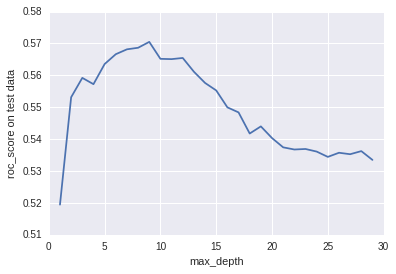

In [44]:
plt.plot(range(1,max_depth), roc_score)
plt.xlabel('max_depth')
plt.ylabel('roc_score on test data')
print('best depth = ', range(1,max_depth)[roc_score.index(max(roc_score))])
print('score = ', max(roc_score))

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
clf = RandomForestClassifier(n_estimators=1200, max_depth=16, n_jobs=7, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=7,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
Y_proba = clf.predict_proba(X_test)
roc_auc = roc_auc_score(Y_test, Y_proba[:,1])

print('score = ', roc_auc)

score =  0.636594310863


# exploring the features

In [257]:
cat_cols = preproc.cat_columns
print(cat_cols)


['VOIE_DEPOT', 'SOURCE_BEGIN_MONTH', 'FISRT_APP_TYPE', 'LANGUAGE_OF_FILLING', 'FISRT_INV_TYPE', 'SOURCE_CITED_AGE', 'SOURCE_IDX_ORI', 'SOURCE_IDX_RAD']


In [258]:
df = df_init.drop(colList, axis=1)
df = preproc.datetime_processings(df)
df = preproc.cat_to_codes(df)

df.head()

,VOIE_DEPOT,COUNTRY,SOURCE_BEGIN_MONTH,APP_NB,APP_NB_PAYS,APP_NB_TYPE,FISRT_APP_TYPE,LANGUAGE_OF_FILLING,NB_CLASSES,NB_ROOT_CLASSES,...,oecd_NB_BACKWARD_PL,oecd_NB_BACKWARD_NPL,IDX_ORIGIN,SOURCE_IDX_ORI,IDX_RADIC,SOURCE_IDX_RAD,VARIABLE_CIBLE,filing-begin,pub-filing,pub_year
0,0,US,0,1,1,1,1,6,2,1,...,0.000000,0.000,1.000000,1,1.00,1,GRANTED,335,212,1997
1,0,DE,0,1,1,1,1,4,2,2,...,0.000000,0.000,1.000000,1,1.00,1,GRANTED,366,181,2001
2,1,JP,0,1,1,1,1,6,4,1,...,0.785714,0.125,0.897778,0,1.00,1,GRANTED,334,214,1993
3,1,GB,0,1,1,1,1,6,2,2,...,0.230769,0.000,1.000000,1,1.00,1,GRANTED,365,184,1995
4,1,DE,0,1,1,1,1,4,1,1,...,0.500000,0.000,0.625000,0,0.25,0,GRANTED,335,212,1990


In [150]:
group = df.groupby(cat_cols).mean().add_suffix('_mean').reset_index()
group['VARIABLE_CIBLE_mean'].head()

0    0.000000
1    1.000000
2    0.000000
3    0.333333
4    1.000000
Name: VARIABLE_CIBLE_mean, dtype: float64

In [151]:
X = df[cat_cols].values
Y = df['VARIABLE_CIBLE'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [152]:
max_depth = 30

roc_score = []
for i in range(1,max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, Y_train)
    
    Y_proba = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(Y_test, Y_proba[:,1])
    roc_score.append(roc_auc)

best depth =  13
score =  0.639908054849


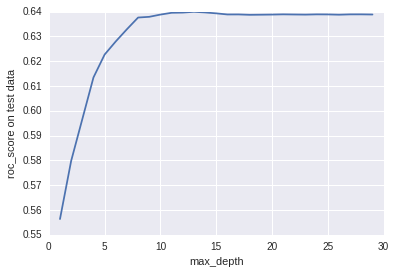

In [153]:
plt.plot(range(1,max_depth), roc_score)
plt.xlabel('max_depth')
plt.ylabel('roc_score on test data')
print('best depth = ', range(1,max_depth)[roc_score.index(max(roc_score))])
print('score = ', max(roc_score))

In [155]:
max_depth = 13

clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf.fit(X_train, Y_train)

Y_proba = clf.predict_proba(X_test)
roc_auc = roc_auc_score(Y_test, Y_proba[:,1])

print('score = ', roc_auc)

score =  0.639879410005


In [157]:
# printing features ordered by importance :
def features_importance(feat_names, feat_importance):
    importance = {feat_names[i]: feat_importance[i] for i in range(len(feat_names))}
    sorted_features = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

    for k,v in sorted_features:
        print('%30a  %5.3f'%(k,v))
        
features_importance(cat_cols, clf.feature_importances_)

                     'COUNTRY'  0.355
          'TECHNOLOGIE_SECTOR'  0.174
         'LANGUAGE_OF_FILLING'  0.129
              'FISRT_APP_TYPE'  0.114
                  'VOIE_DEPOT'  0.068
          'SOURCE_BEGIN_MONTH'  0.068
              'SOURCE_IDX_ORI'  0.036
              'FISRT_INV_TYPE'  0.027
              'SOURCE_IDX_RAD'  0.018
            'SOURCE_CITED_AGE'  0.012


Parmis les variables catégorielles, celle qui est la plus influente sur le résultat du brevet, est country. Puis vient technologie_sector.

On va ajouter des scores dans la class Preprocessings pour tenir compte de ces résultats.

Pour la random forest le score est 0.663 avec le score success_index1, 0.65 avec success_index1 et country_score.

Si on enlève ensuite les colonnes oneHot de country et tech_sector pour ne garder que les scores ? ==> Les résulats sont moins bons.

# Testing data separability

In [75]:
def data_split_scores(df, categorical_cols, print_results=10):

    Ltot = len(df)

    scores = {}
    for col in categorical_cols:
        groups = df.groupby(col).median().reset_index()
        groups = groups.transpose()
        groups['diff'] = groups[1] - groups[0]

        norm = np.linalg.norm(groups['diff'].values)
        
        p0 = df[col].value_counts()[0] / Ltot
        p1 = df[col].value_counts()[1] / Ltot
        entropy = -p0*math.log10(p0) - p1*math.log10(p1)

        groups_count = df.groupby((col,'VARIABLE_CIBLE')).count().reset_index().iloc[:,3].values
        groups_count = np.asarray(groups_count)

        groups_proba =  - groups_count/Ltot * np.log10(groups_count/Ltot)
        tot_entropy = sum(groups_proba)

        score = norm * entropy * tot_entropy

        if len(groups_count) == 4:
            scores[col] = score
            
    scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
    
    if print_results != None:
        i = 0
        for k,v in scores:
            if i >= print_results:
                break
            print('%30a  %5.3f'%(k,v))
            i += 1
            
    return scores

In [76]:
sorted_scores = data_split_scores(df_train, preproc.categorical_cols)

VOIE_DEPOT
1    113441
0     94103
Name: VOIE_DEPOT, dtype: int64
SOURCE_BEGIN_MONTH
0    190003
1     17541
Name: SOURCE_BEGIN_MONTH, dtype: int64
SOURCE_CITED_AGE
1    134021
0     73523
Name: SOURCE_CITED_AGE, dtype: int64
SOURCE_IDX_ORI
1    134021
0     73523
Name: SOURCE_IDX_ORI, dtype: int64
SOURCE_IDX_RAD
1    170332
0     37212
Name: SOURCE_IDX_RAD, dtype: int64
COUNTRY_0
0    207543
1         1
Name: COUNTRY_0, dtype: int64
COUNTRY_1
0    207498
1        46
Name: COUNTRY_1, dtype: int64
COUNTRY_2
0    206044
1      1500
Name: COUNTRY_2, dtype: int64
COUNTRY_3
0    206310
1      1234
Name: COUNTRY_3, dtype: int64
COUNTRY_4
0    207542
1         2
Name: COUNTRY_4, dtype: int64
COUNTRY_5
0    207049
1       495
Name: COUNTRY_5, dtype: int64
COUNTRY_6
0    207522
1        22
Name: COUNTRY_6, dtype: int64
COUNTRY_7
0    207394
1       150
Name: COUNTRY_7, dtype: int64
COUNTRY_8
0    207537
1         7
Name: COUNTRY_8, dtype: int64
COUNTRY_9
0    207046
1       498
Name: COUNTRY_9,

In [77]:
df_train0 = df_train[df_train.SOURCE_CITED_AGE == 0]
df_train1 = df_train[df_train.SOURCE_CITED_AGE == 1]

/home/maxime/local/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


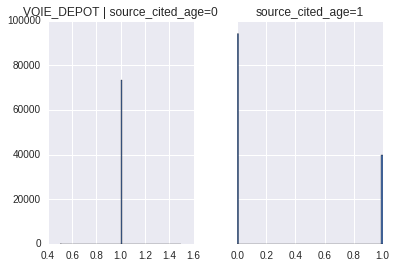

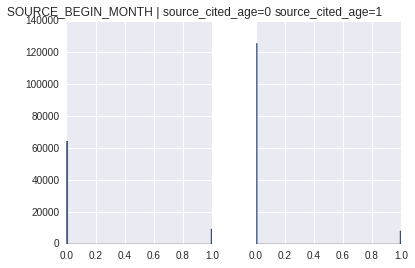

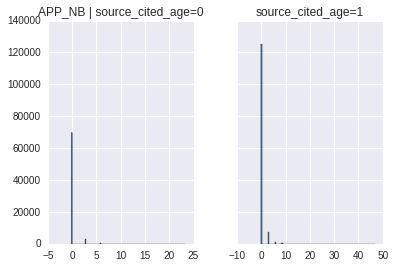

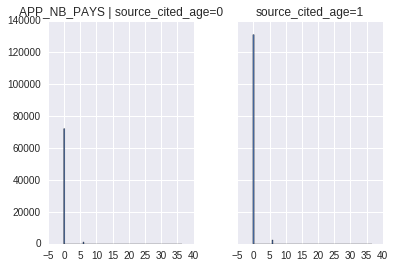

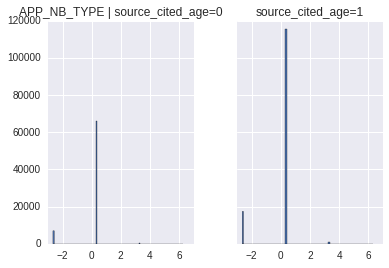

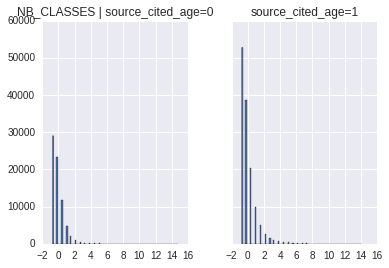

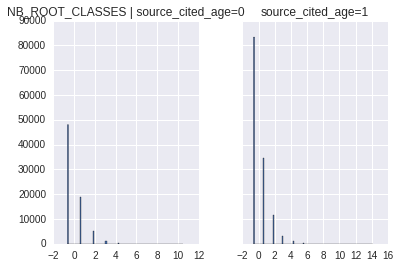

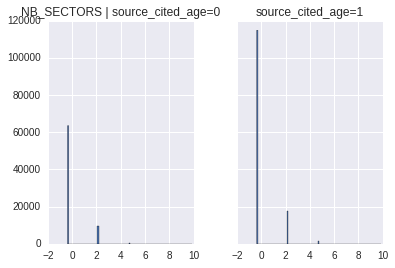

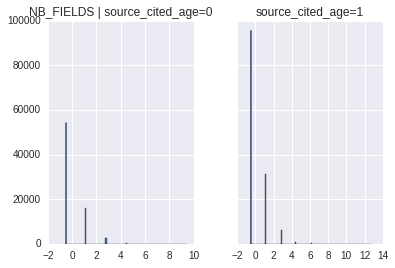

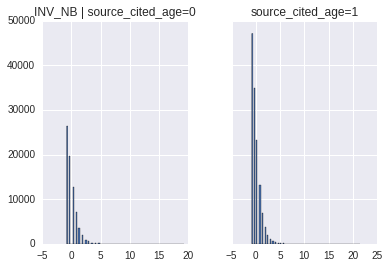

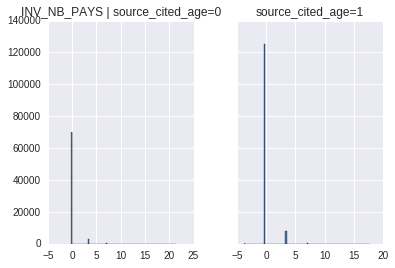

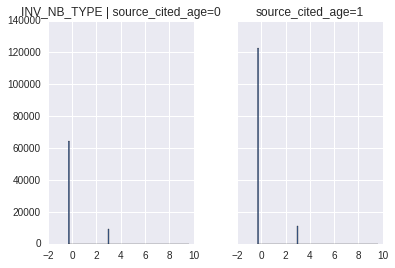

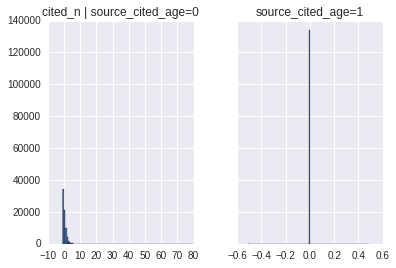

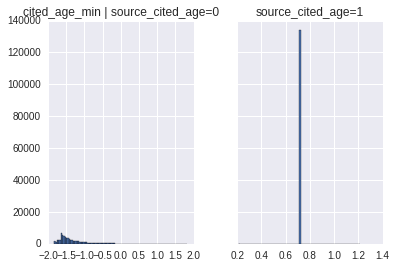

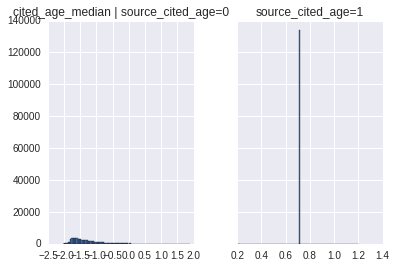

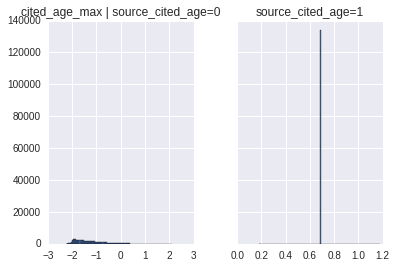

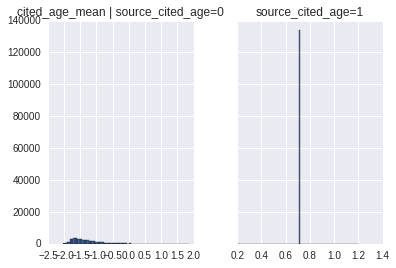

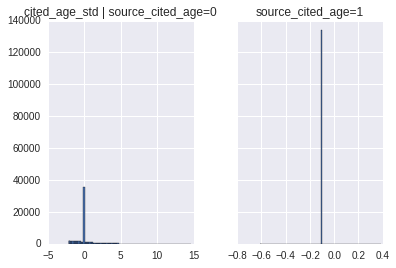

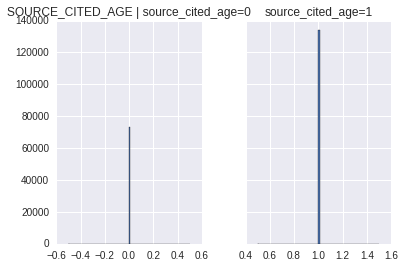

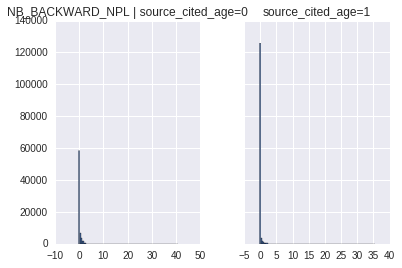

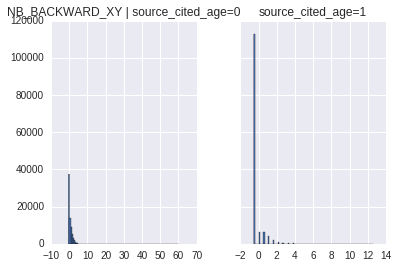

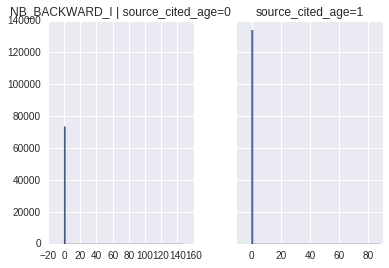

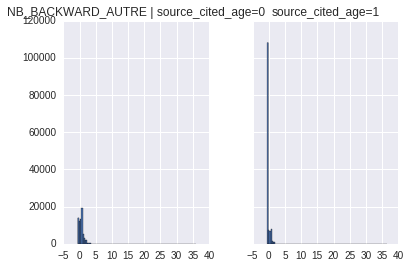

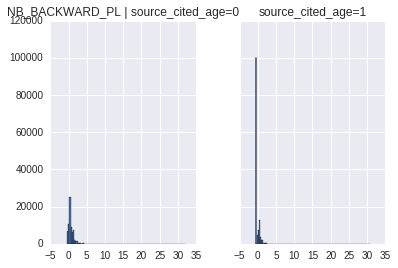

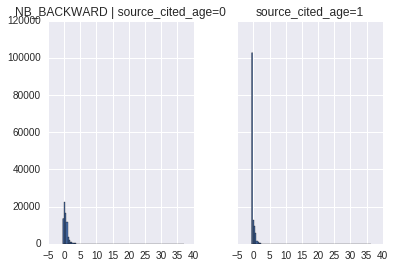

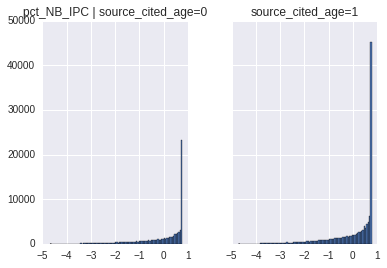

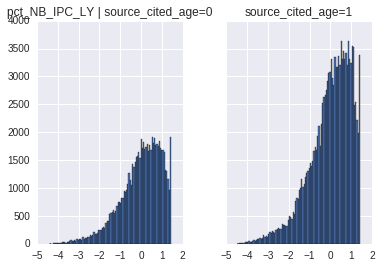

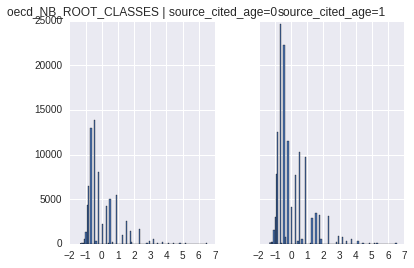

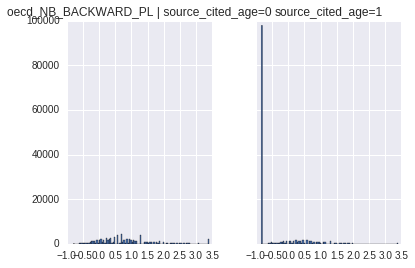

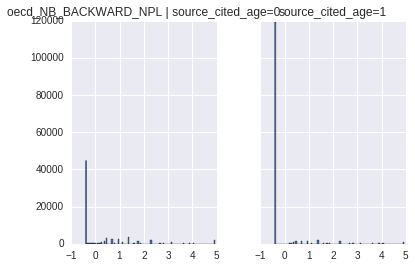

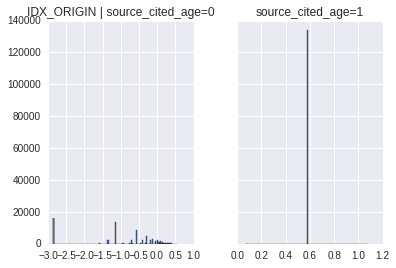

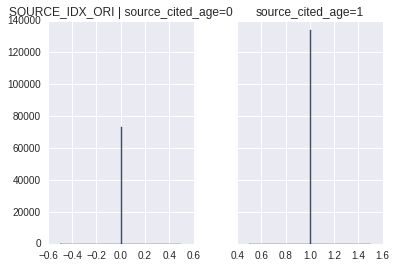

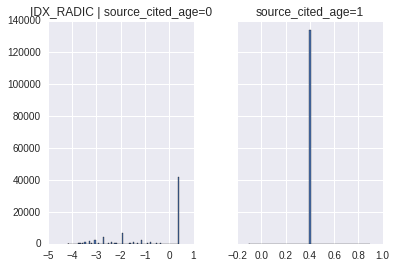

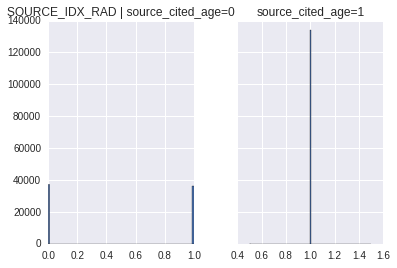

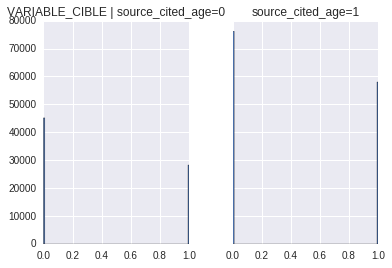

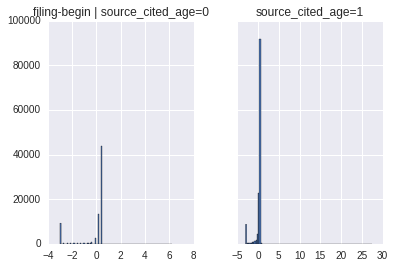

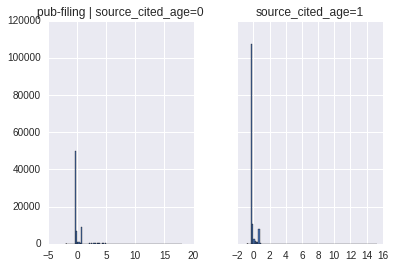

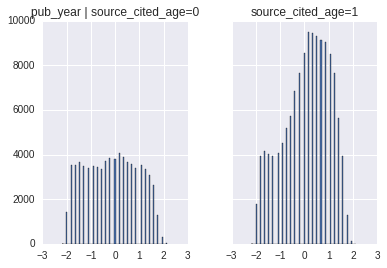

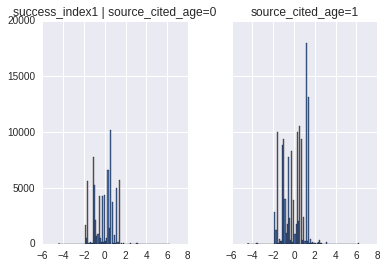

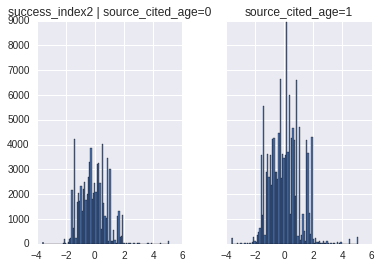

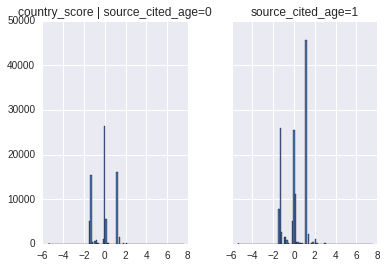

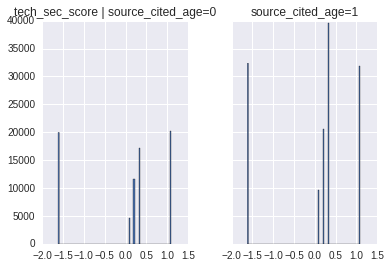

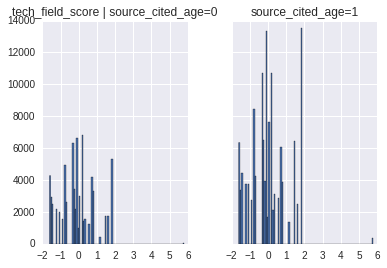

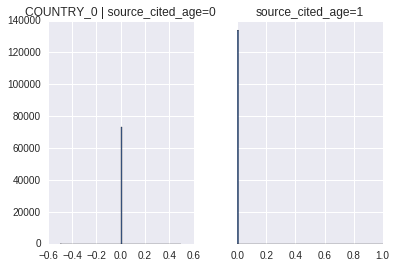

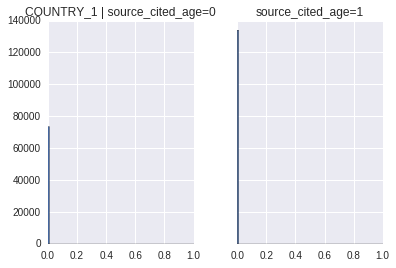

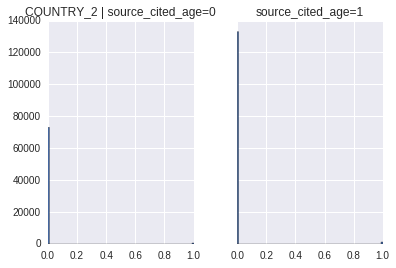

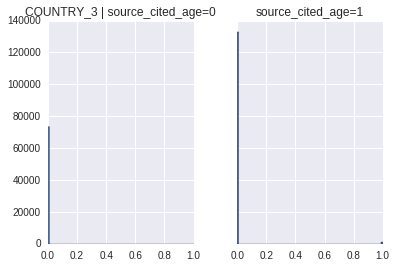

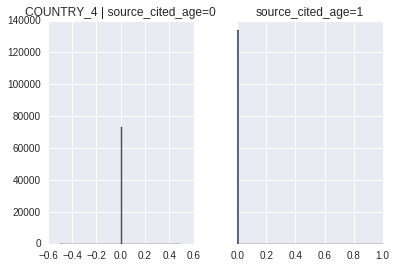

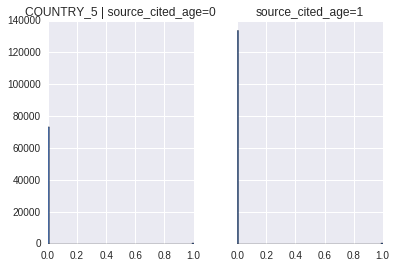

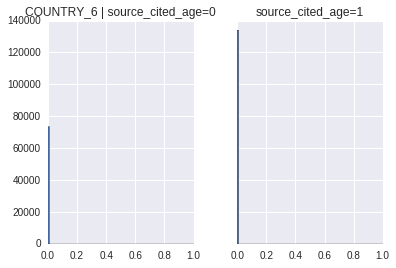

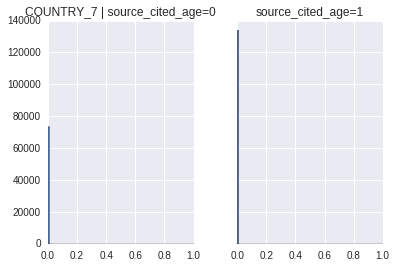

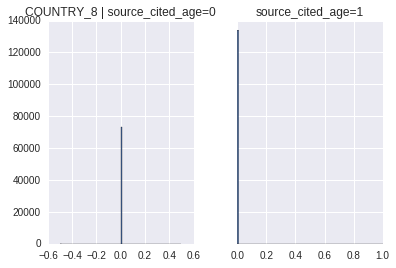

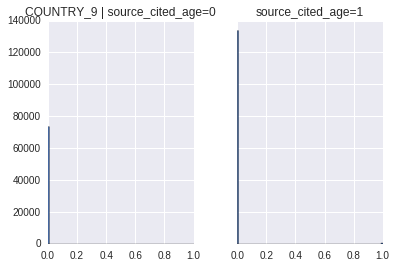

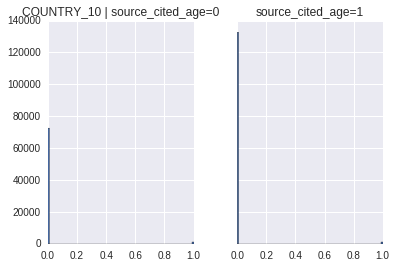

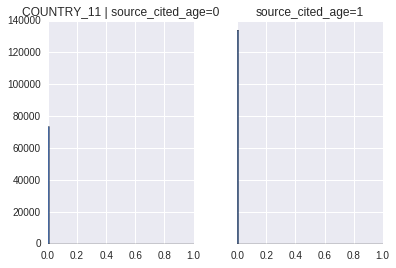

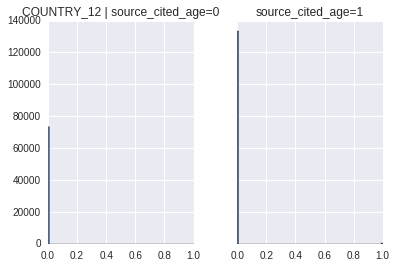

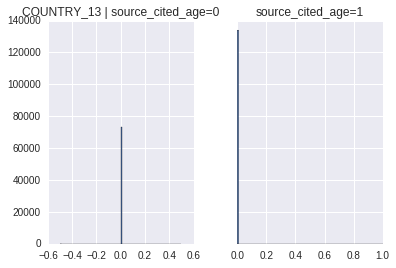

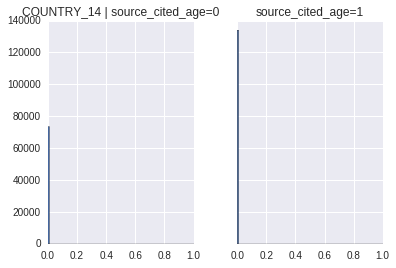

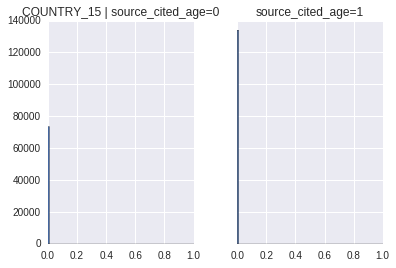

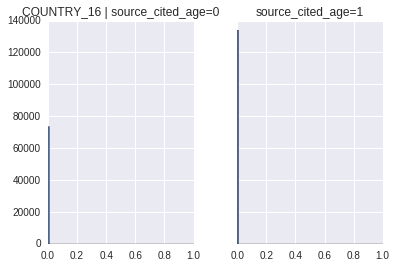

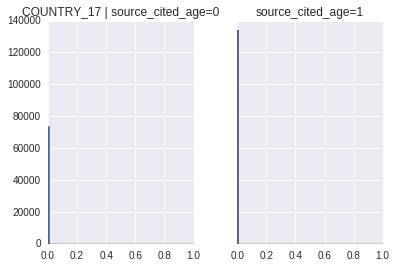

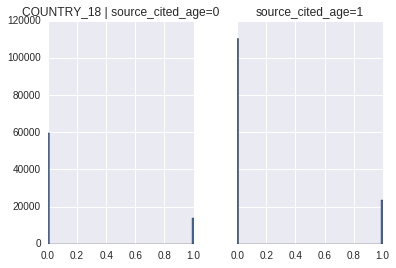

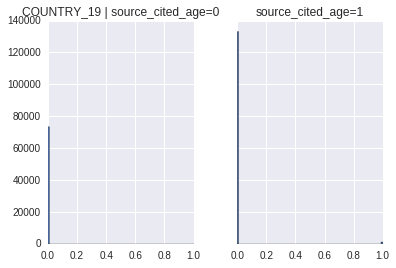

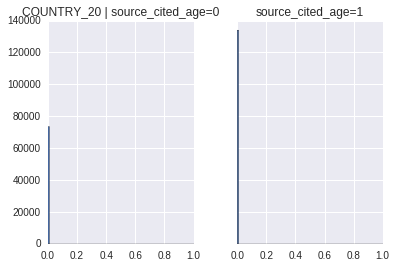

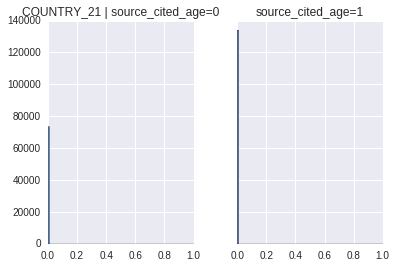

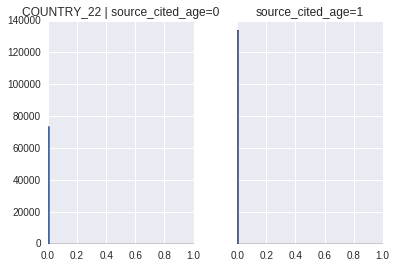

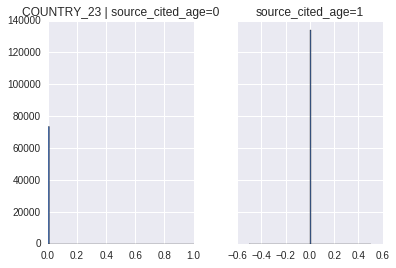

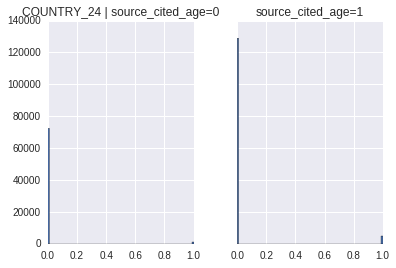

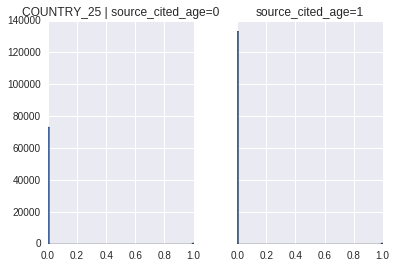

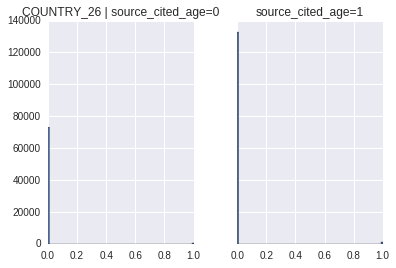

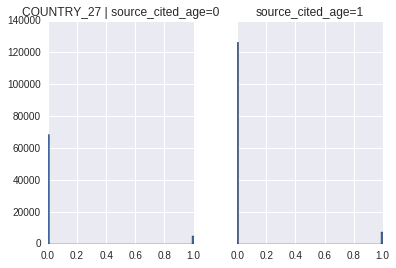

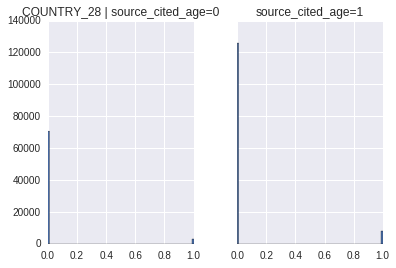

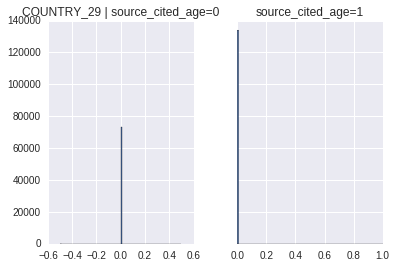

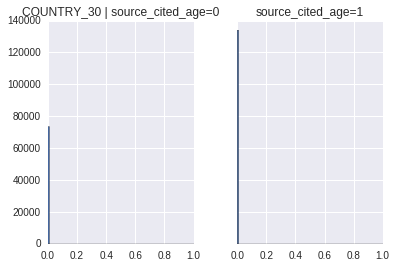

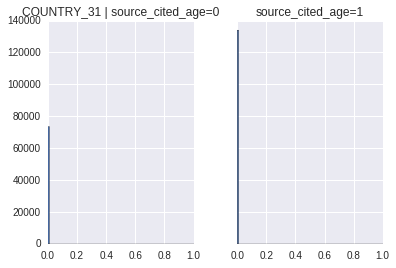

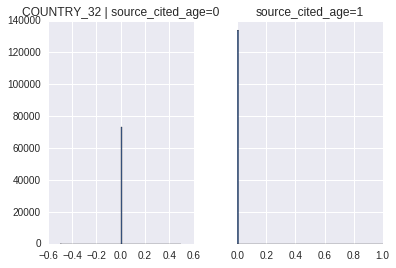

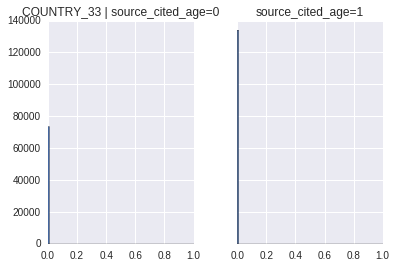

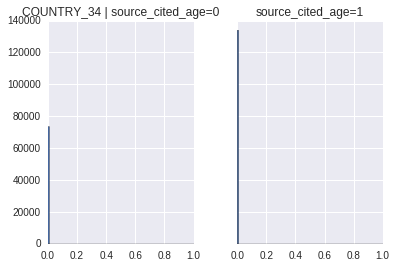

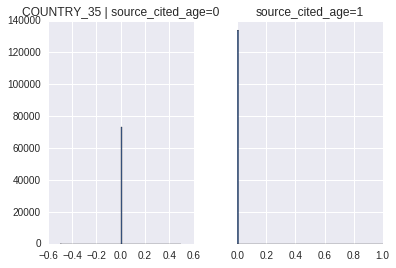

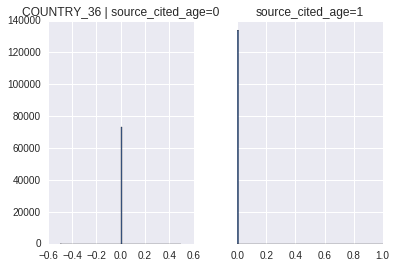

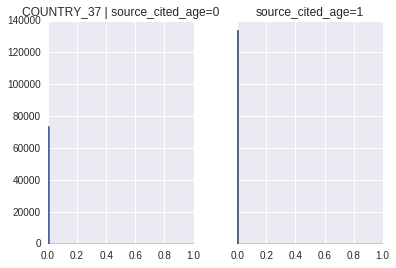

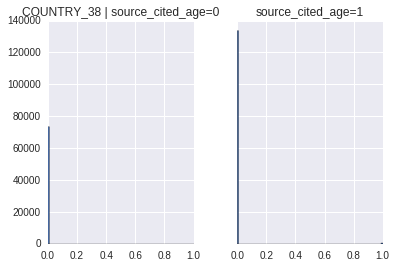

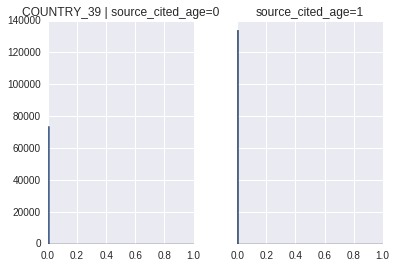

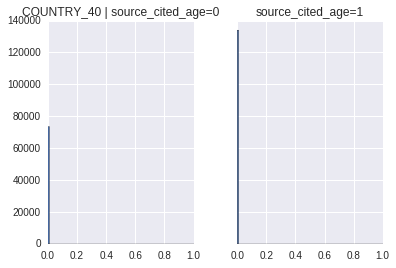

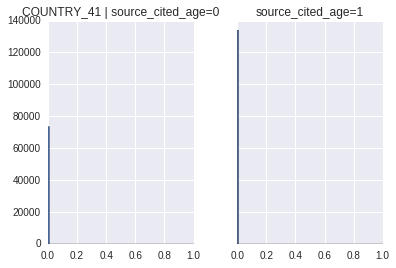

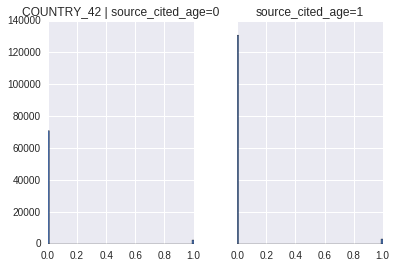

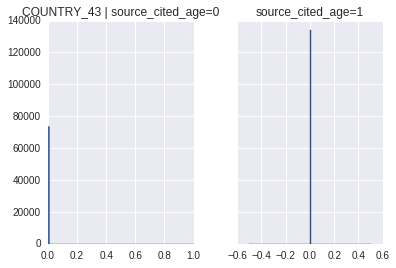

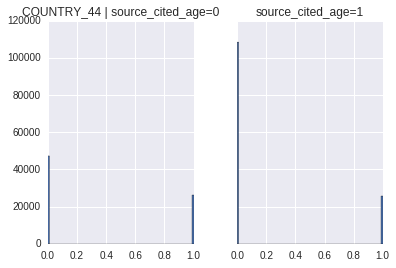

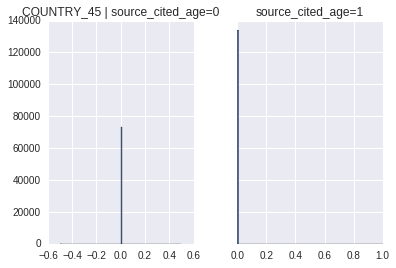

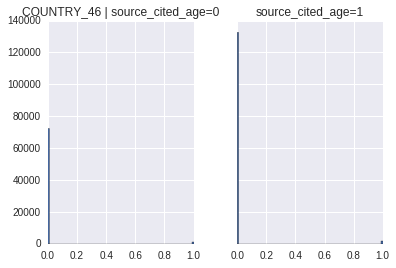

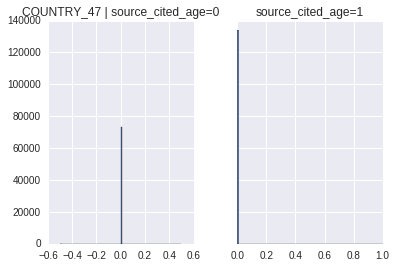

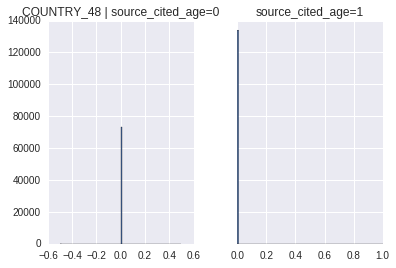

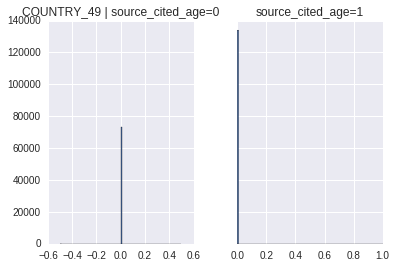

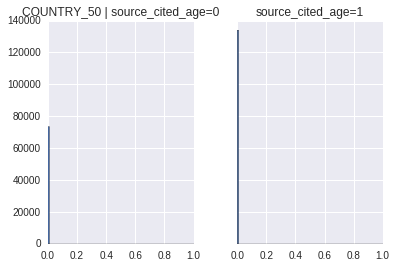

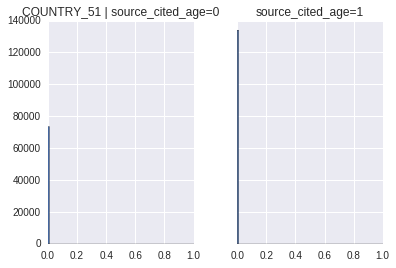

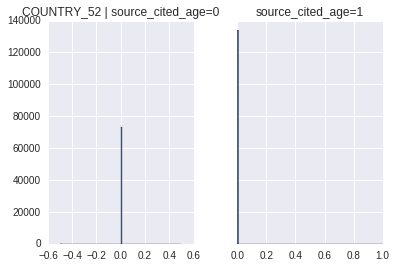

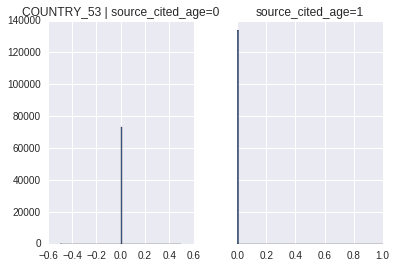

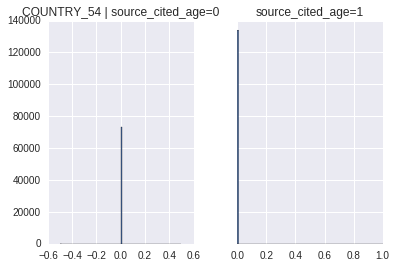

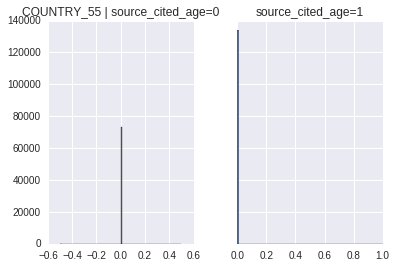

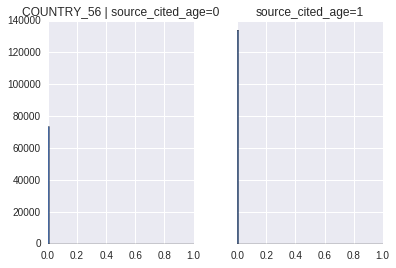

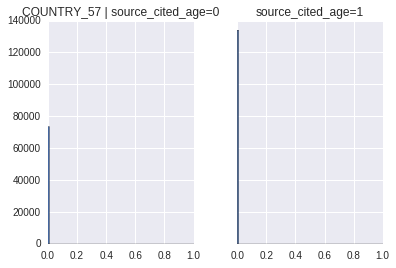

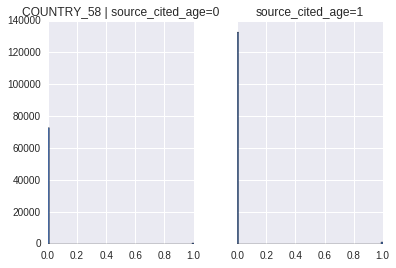

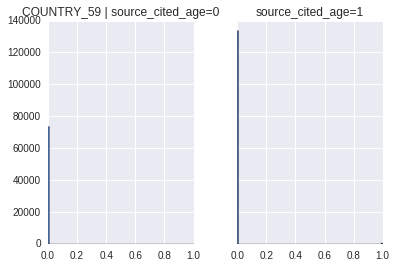

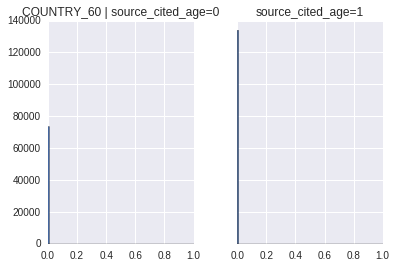

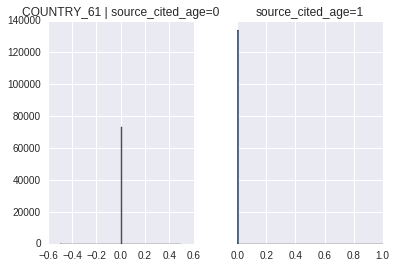

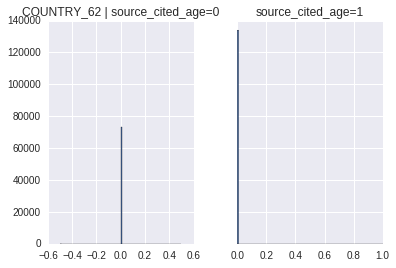

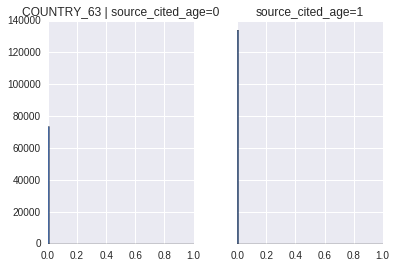

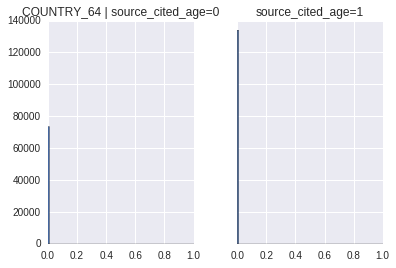

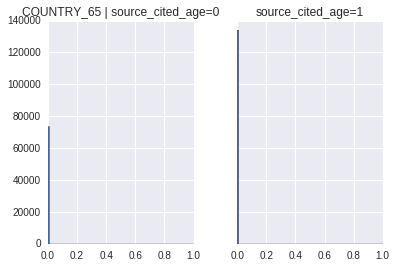

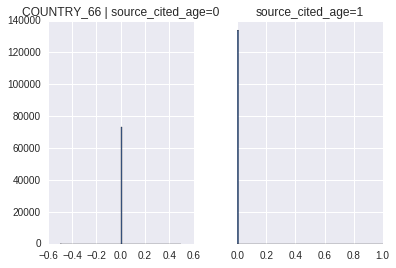

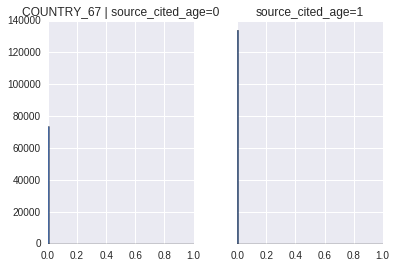

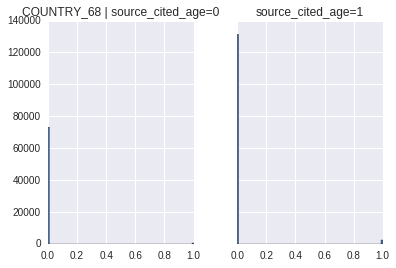

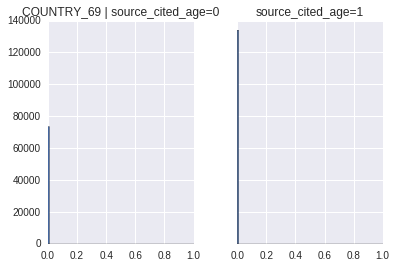

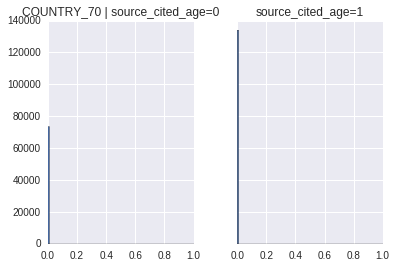

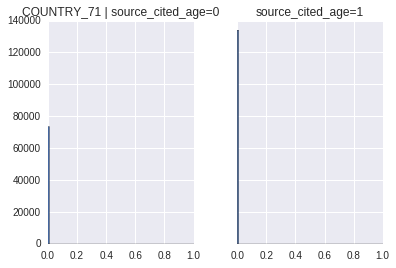

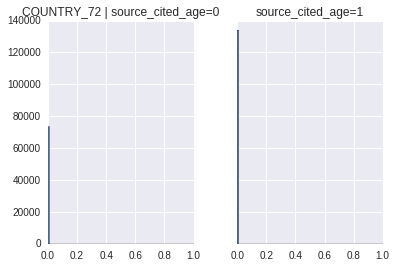

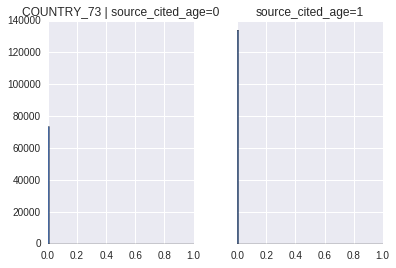

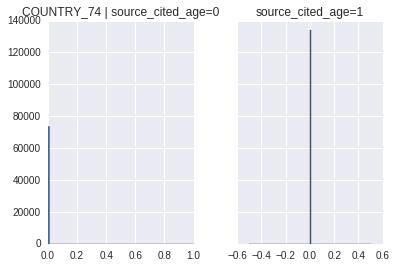

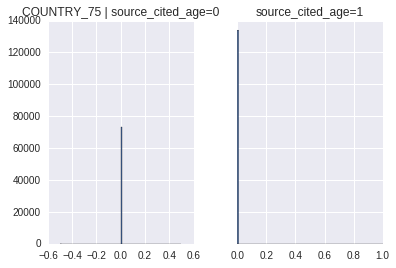

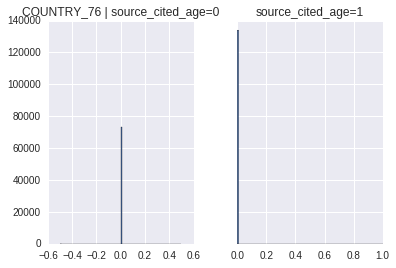

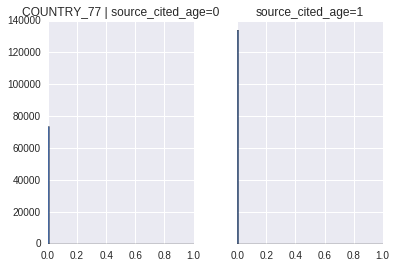

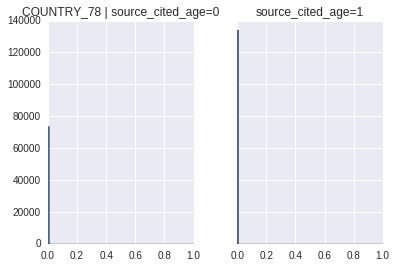

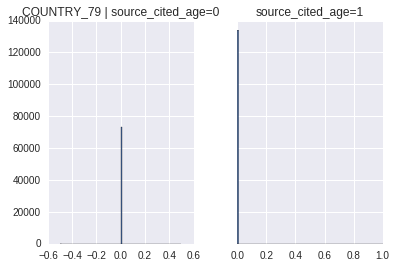

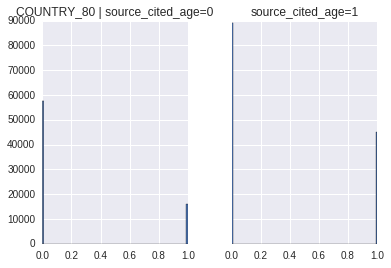

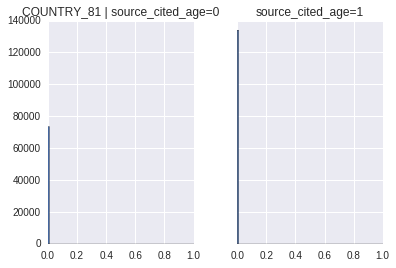

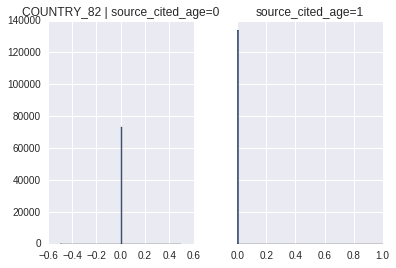

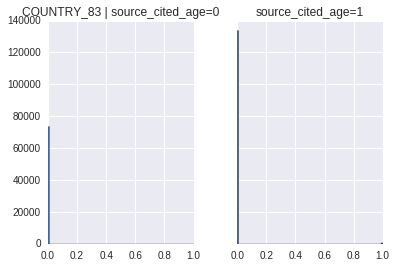

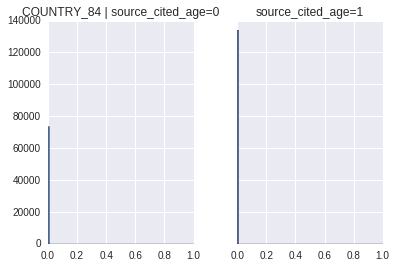

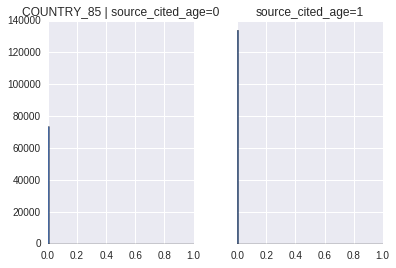

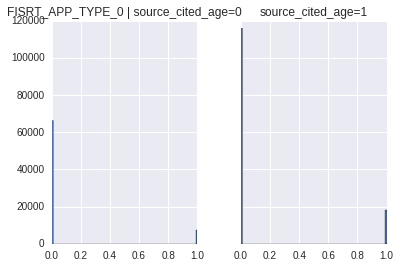

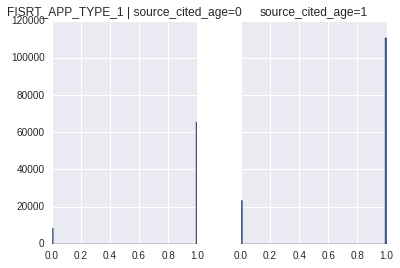

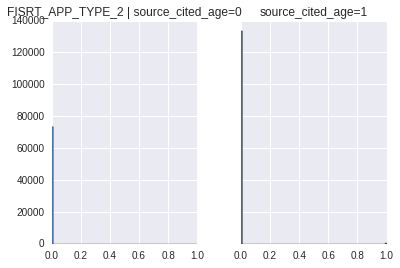

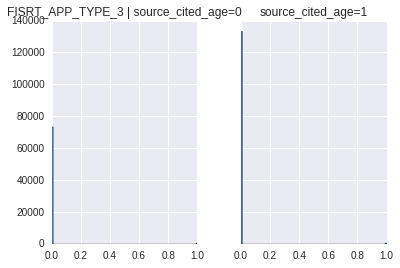

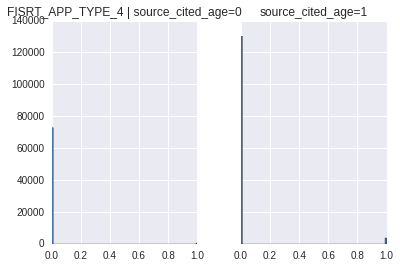

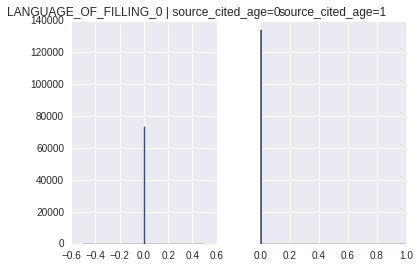

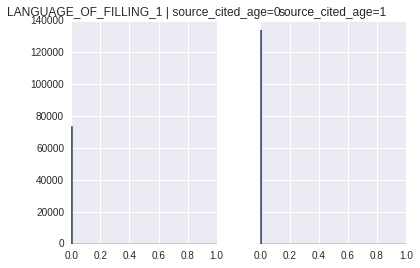

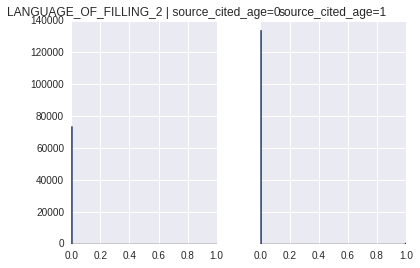

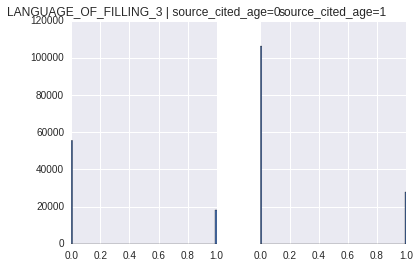

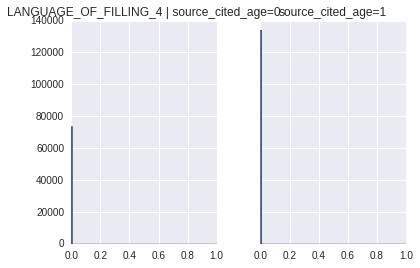

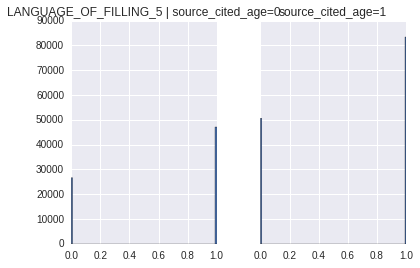

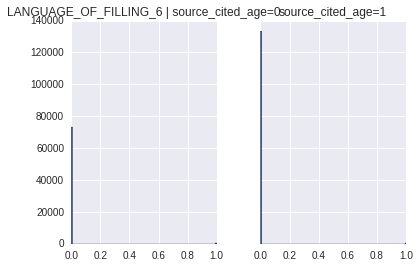

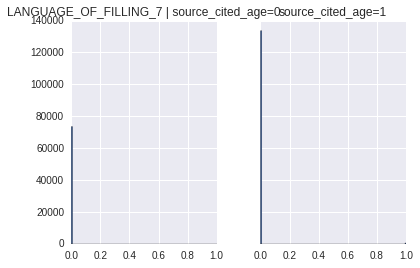

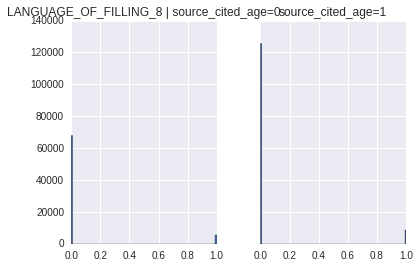

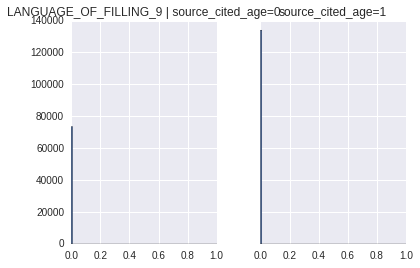

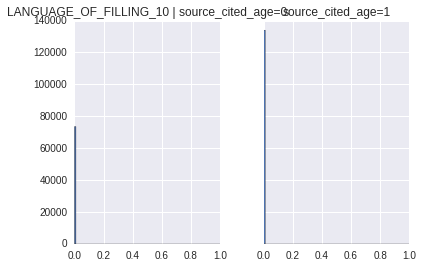

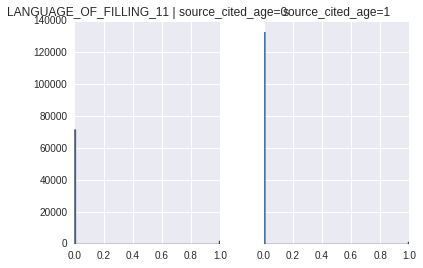

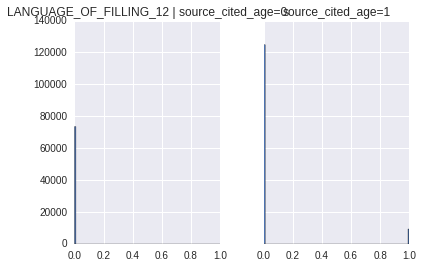

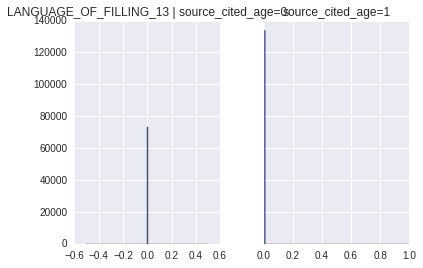

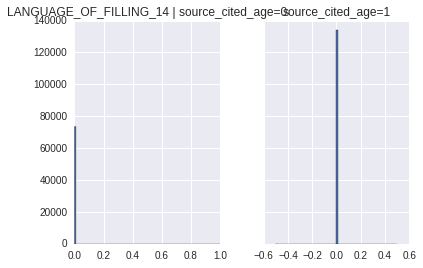

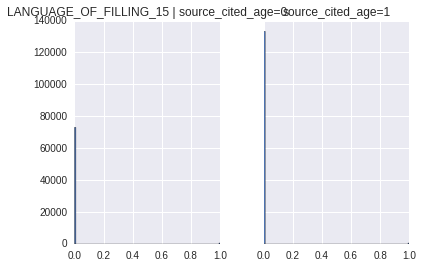

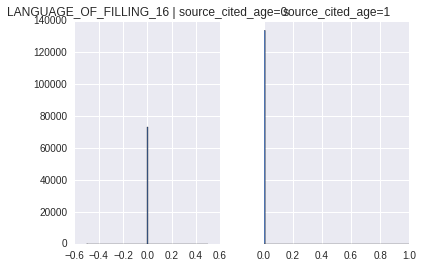

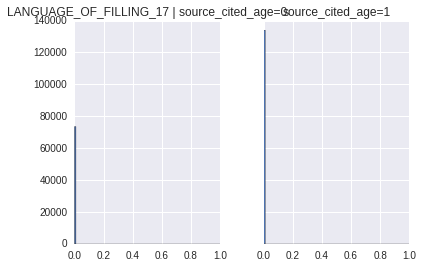

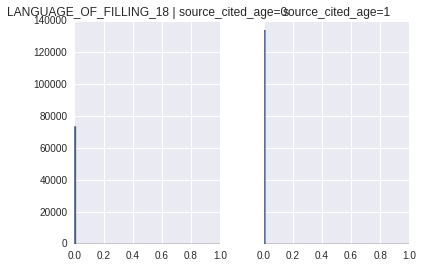

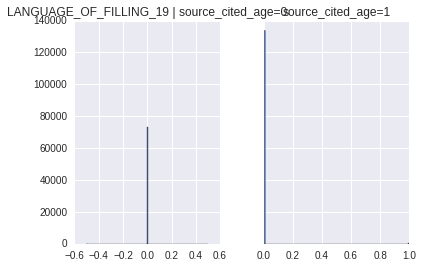

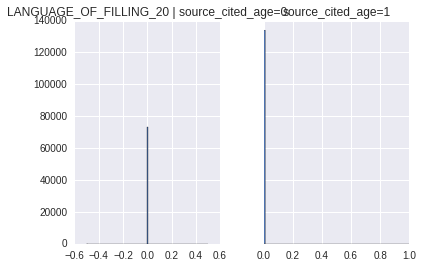

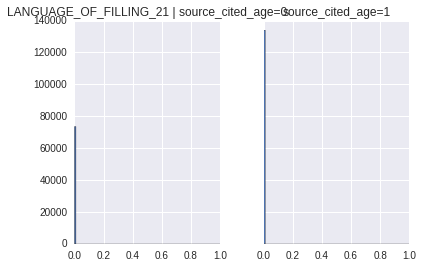

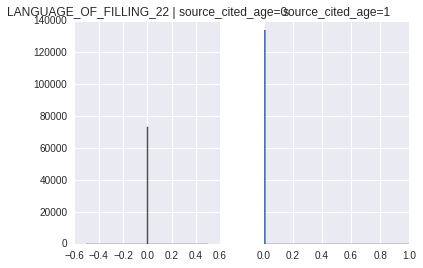

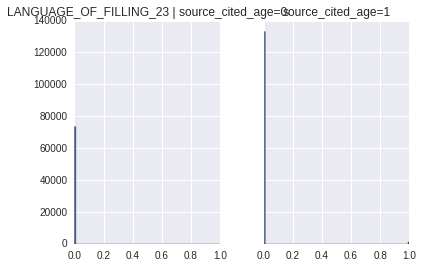

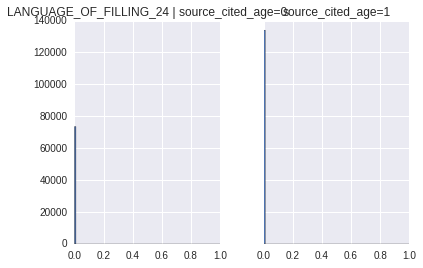

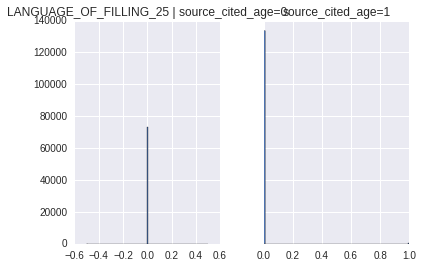

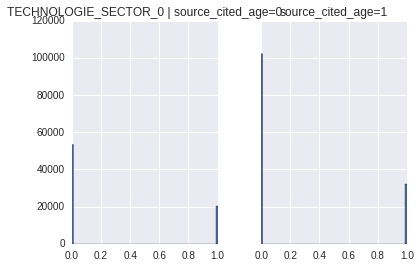

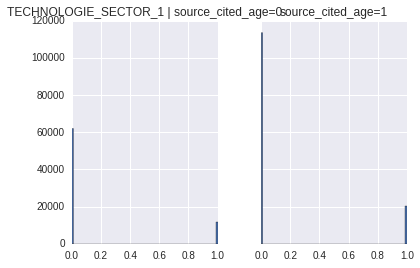

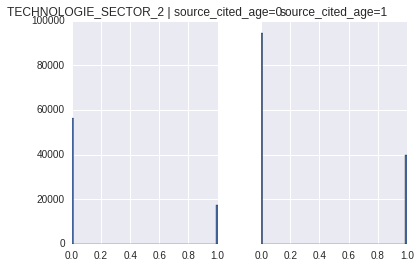

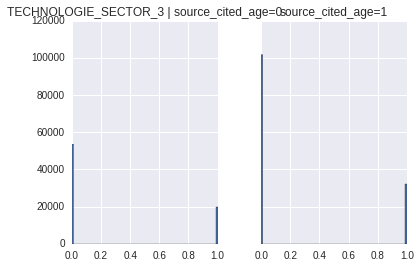

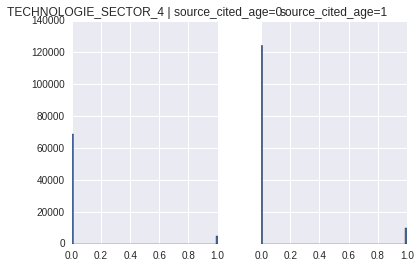

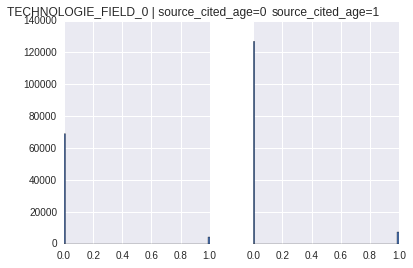

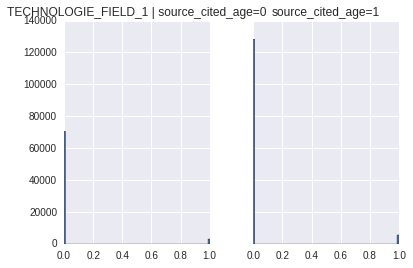

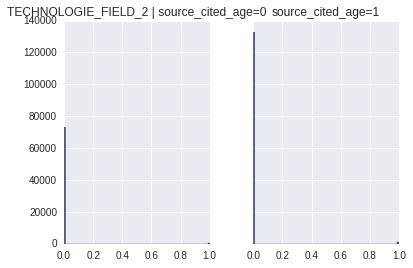

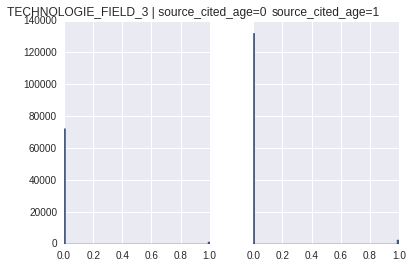

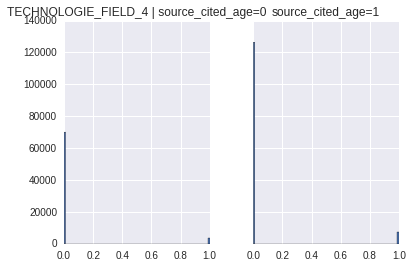

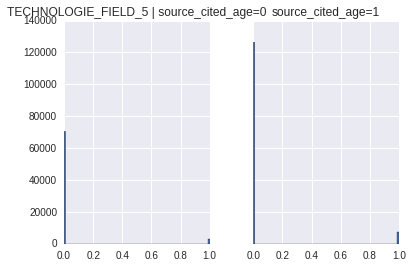

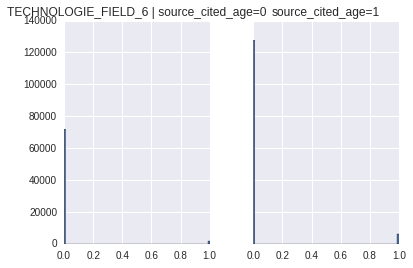

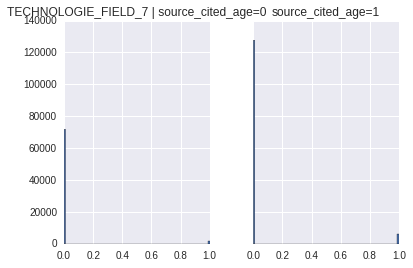

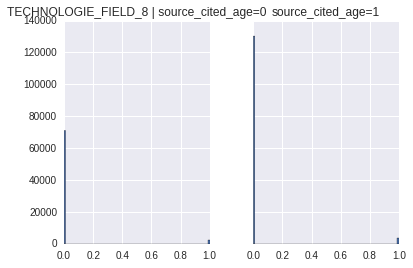

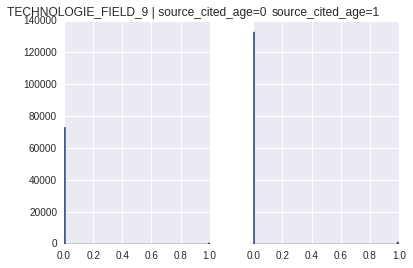

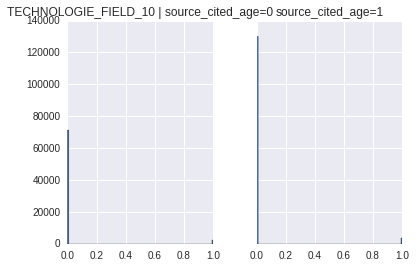

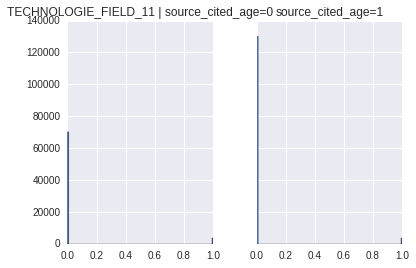

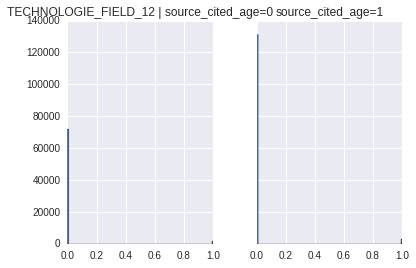

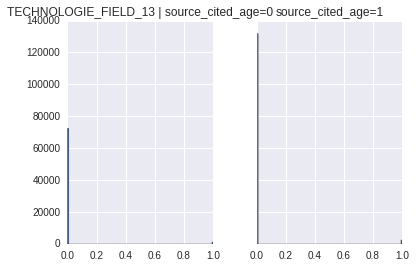

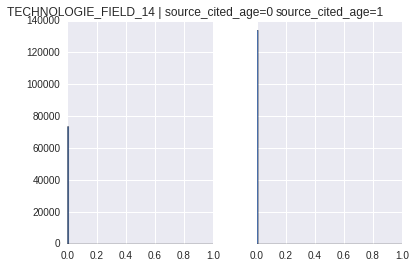

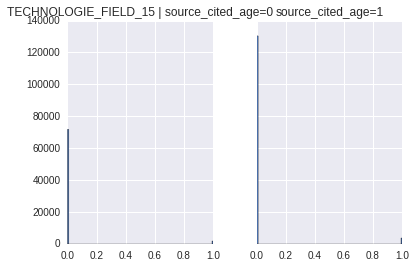

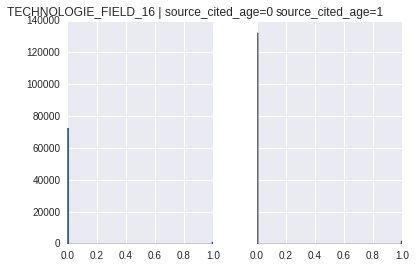

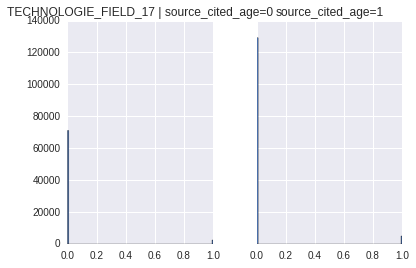

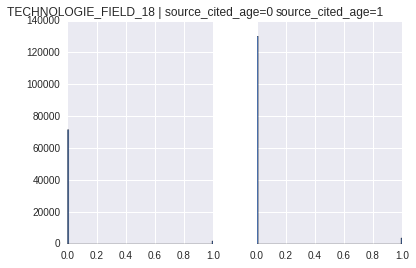

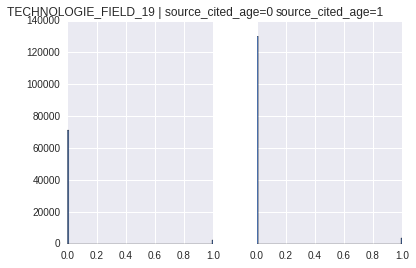

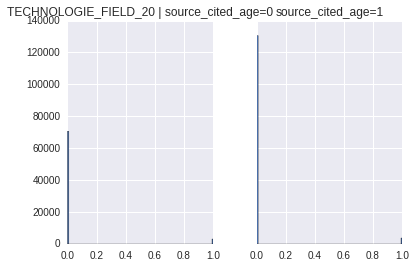

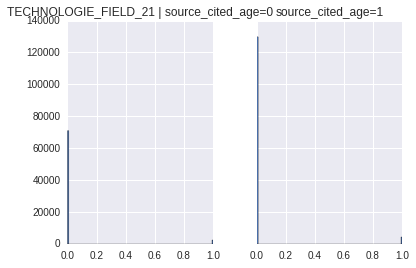

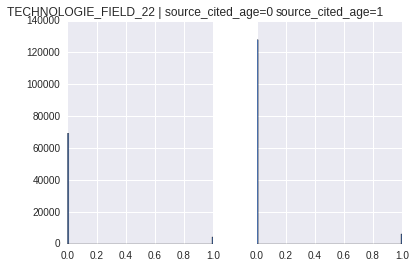

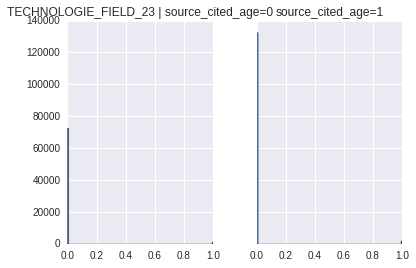

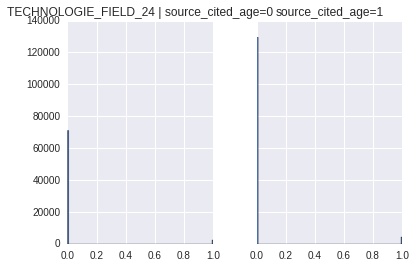

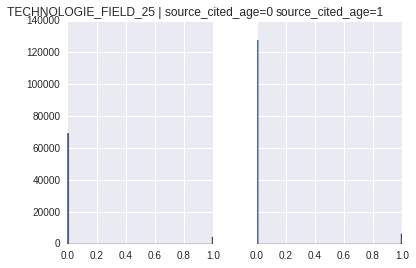

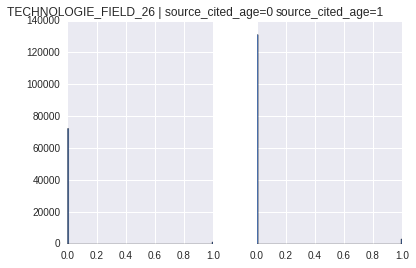

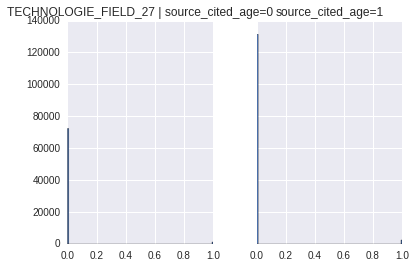

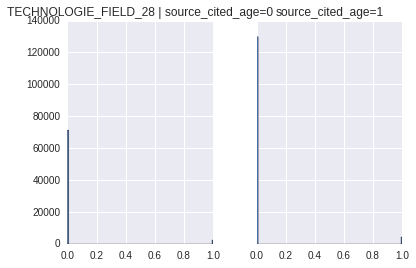

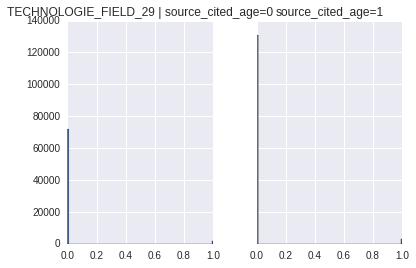

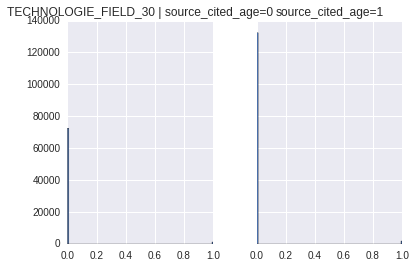

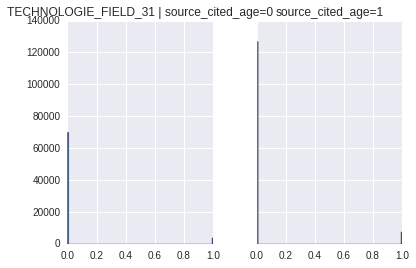

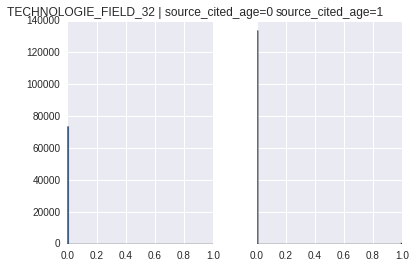

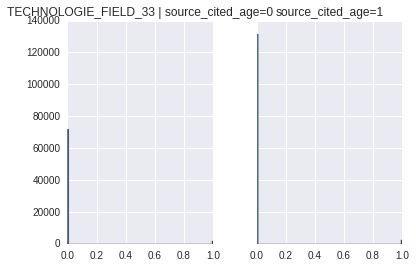

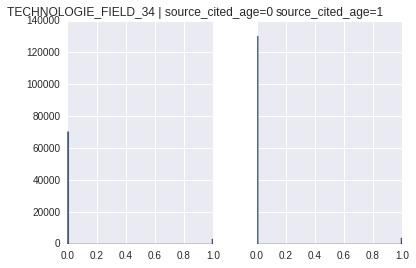

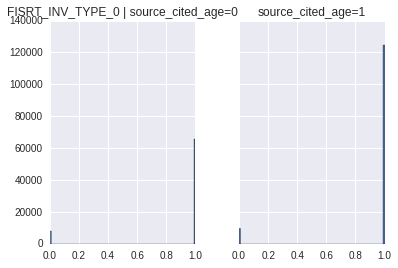

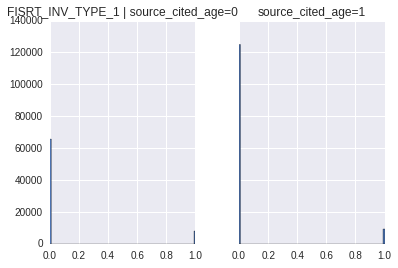

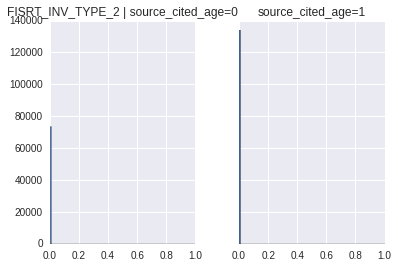

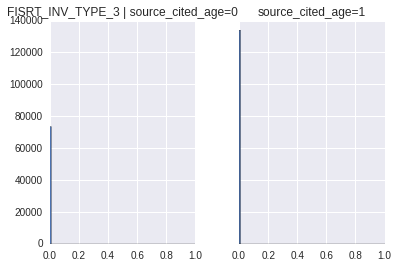

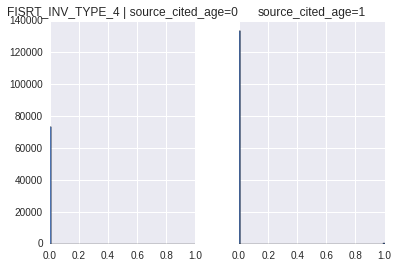

In [78]:
for col in df_train0.columns:
    plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    df_train0.hist(col, bins=100, ax=ax1)
    df_train1.hist(col, bins=100, ax=ax2)
    ax1.set_title(col+' | source_cited_age=0')
    ax2.set_title('source_cited_age=1')
